<img src="img/filter.png" width="200" align="right">
Python provides a few higher order (or functional programming) functions in the standard library that can be quite useful:

* map
* filter
* reduce
* lambda
* list comprehensions

<div align="right"><i>Picture from <a href="https://netflix.github.io/">Netflix OSS</a></i></div>

This article series focuses on exploring these. In the previous article we've taken a look at the [`map`](higher-level-functions-python-map.html) and [`reduce`](higher-level-functions-python-reduce) functions, that take other functions as arguments. In this notebook, we'll learn more about the `filter` function in Python. Again, I will assume you already know about list expressions, (or more broadly, [generator expressions](https://nedbatchelder.com/blog/201605/generator_comprehensions.html)).

In [1]:
help(filter)

Help on class filter in module builtins:

class filter(object)
 |  filter(function or None, iterable) --> filter object
 |  
 |  Return an iterator yielding those items of iterable for which function(item)
 |  is true. If function is None, return the items that are true.
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.



And from the [official Python documentation]():
>**`filter(function, iterable)`**

>    Construct an iterator from those elements of iterable for which function returns true. iterable may be either a sequence, a container which supports iteration, or an iterator. If function is `None`, the identity function is assumed, that is, all elements of iterable that are false are removed.

>    Note that `filter(function, iterable)` is equivalent to the generator expression `(item for item in iterable if function(item))` if function is not `None` and `(item for item in iterable if item)` if function is `None`.


So `filter` takes a two arguments: a function and an iterable. Let's start with a few imports and work our way up to a simple use case.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import operator  # base Python functions
from time import time

In [3]:
sales = [1234, 2345, 3456, 4567, 65865]

Here's the "traditional" way of filtering a list:

In [4]:
result = []
for sale in sales:
    if sale > 3000:
        result.append(sale)
print(result)

[3456, 4567, 65865]


Now with a list expression:

In [5]:
[sale for sale in sales if sale > 3000]

[3456, 4567, 65865]

And finally, with `filter`:

In [6]:
list(filter(lambda sale: sale > 3000, sales))

[3456, 4567, 65865]

Like generator expressions, `map` and `reduce`, we need to wrap `filter` with a call to `list()` in order to "consume" the items in the generator. Otherwise they stay untouched, and out of memory. This attribute is called [*lazy evaluation*](https://en.wikipedia.org/wiki/Lazy_evaluation).

## Can it be useful?
Well, that's a tough one, isn't it? One way I see people saying it's useful is for lists of things that need a function applied to see if they're to be filtered or not.

From the Stack Overflow post [list comprehension vs. lambda + filter](https://stackoverflow.com/questions/3013449/list-comprehension-vs-lambda-filter) by user I. J. Kennedy:

>A very frequent use case is pulling out the values of some iterable X subject to a predicate P(x):

>`[x for x in X if P(x)]`

>but sometimes you want to apply some function to the values first:

>`[f(x) for x in X if P(f(x))]`


In [7]:
def gross_sales(n: int):
    """Simple function with product and addition, for testing"""
    return int(n * 1.11435 + 1)

for s in sales:
    if gross_sales(s) > 3000:
        print(gross_sales(s))

3852
5090
73397


In [8]:
[gross_sales(s) for s in sales if gross_sales(s) > 3000]

[3852, 5090, 73397]

In [9]:
list(filter(lambda x: x > 3000, map(gross_sales, sales)))

[3852, 5090, 73397]

Which is really elegant and easy to read! And it eliminates the need to recalculate the function `gross_sales` twice, right?

I would contend that's it's a non-issue, and can be circumvented easily by using `map`. We can just map the function first and filter with a list comprehension:

In [10]:
[s for s in map(gross_sales, sales) if s > 3000]

[3852, 5090, 73397]

## Benchmarks

In [11]:
def time_filter(sales_list):
    t0 = time()
    sum(filter(lambda x: x > 3000, map(gross_sales, sales_list)))
    return time() - t0


def time_map_list_comp(sales_list):
    t0 = time()
    # This is actually called a generator expression
    # It does not generate the list items ahead of time
    # Items are calculated lazily, like `filter` results
    sum(s for s in map(gross_sales, sales_list) if s > 3000)
    return time() - t0


def time_list_comp(sales_list):
    t0 = time()
    # This is actually called a generator expression
    # It does not generate the list items ahead of time
    # Items are calculated lazily, like `filter` results
    sum(gross_sales(s) for s in sales_list if gross_sales(s) > 3000)
    return time() - t0


test_range = [list(np.random.randint(0, 100000, size=2**x)) for x in range(10, 23)]
times_filter = [time_filter(s) for s in test_range]
times_map_list_comp = [time_map_list_comp(s) for s in test_range]
times_list_comp = [time_list_comp(s) for s in test_range]

df_filter = pd.DataFrame([times_filter, times_map_list_comp, times_list_comp]).T
df_filter.columns = ['filter', 'map_list_comp', 'list_comp']
df_filter.index = [len(s) for s in test_range]
df_filter

,filter,map_list_comp,list_comp
1024,0.003,0.002,0.005
2048,0.004,0.004,0.008
4096,0.008,0.008,0.017
8192,0.017,0.017,0.034
16384,0.037,0.034,0.068
32768,0.071,0.085,0.137
65536,0.141,0.136,0.266
131072,0.281,0.278,0.542
262144,0.599,0.558,1.084
524288,1.148,1.096,2.237


Text(0,0.5,'Compute time (s)')

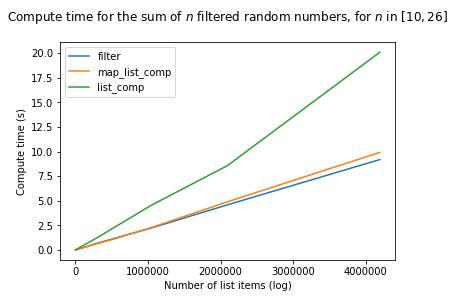

In [13]:
df_filter.plot()
plt.title('Compute time for the sum of $n$ filtered random numbers, for $n$ in $[10, 26]$\n')
plt.xlabel('Number of list items')
plt.ylabel('Compute time (s)')

So it would seem that using either `filter(map(func, iterable))` and filtering through a list comprehension both basically have the same performance.

It would appear as though, along with `reduce`, the specific uses for `filter` are quite limited, if not non-existant. In fact, `filter()`'s effects can be achieved though other means that are:
1. Just as readable, and
2. Just as fast.

## Conclusions
I wish the conclusion to our Higher Level Functions in Python didn't end on such a cliff dive! As we've just seen, there does not seem to be any good uses for `filter` in Python that can't be achieved in ways that are just as readable, and just as fast. I might need to get back to this statement later if I find one, though. Do tweet at me if you find compelling evidence suggesting otherwise! 😀

---

To recap, we've taken a look at the Python functions `map()`, `functools.reduce()` and `filter()`, and seen the various ways with which they can make code more readable, or enhance performance in some bottlenecks without sacrificing clarity in the code.

In [our first installment](higher-level-functions-python-map.html), we saw that `map()` can be a useful way to apply a function to every item in an iterable, and that it can easily fit in everyday code.

In our [second article](higher-level-functions-python-reduce.html), we took a look at the `reduce()` function, and were able to find a few niche applications where it might be useful, related to function composition and in some ways, metaprogramming.

Finally, we've now seen that the `filter()` function, while elegant and clear in its syntax, can have its effects recreated just as easily with list or generator comprehensions. Of all the various language elements that Python has inherited from "functional programming", it might just be the one that serves no clear use. I find it funny that Guido famously moved `reduce` to the functools module, but that `filter` might have been the clearer candidate!